# Model-theoretic ontology embedding methods

## EL-Embeddings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install mowl-borg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.7/717.7 KB 50.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.2/449.2 KB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.6 MB/s eta 0:00:00
  Created wheel for temp: filename=temp-2020.7.2-py3-none-any.whl size=1277 sha256=461df36c040e3655119920ec204dcd23

Import MOWL library and ELEmbedding model base classes

In [3]:
import mowl
mowl.init_jvm("10g")

from mowl.models.elembeddings.module import ELEmModule
from mowl.base_models.elmodel import EmbeddingELModel


Define the model and training strategy

In [4]:
import torch
from torch import nn
from tqdm import trange
import numpy as np

class ELEmbeddings(EmbeddingELModel):

    def __init__(self,
                 dataset,
                 embed_dim=50,
                 margin=0,
                 reg_norm=1,
                 learning_rate=0.001,
                 epochs=1000,
                 batch_size=4096 * 8,
                 model_filepath=None,
                 device='cpu'
                 ):
        super().__init__(dataset, batch_size, extended=True, model_filepath=model_filepath)

        self.embed_dim = embed_dim
        self.margin = margin
        self.reg_norm = reg_norm
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.device = device
        self._loaded = False
        self._loaded_eval = False
        self.extended = False
        self.init_model()

    def init_model(self):
        self.model = ELEmModule(
            len(self.class_index_dict),  # number of ontology classes
            len(self.object_property_index_dict),  # number of ontology object properties
            embed_dim=self.embed_dim,
            margin=self.margin
        ).to(self.device)

    def train(self, checkpoint=1):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        best_loss = float('inf')

        for epoch in trange(self.epochs):
            self.model.train()

            train_loss = 0
            loss = 0

            # Notice how we use the ``training_datasets`` variable directly
            # and every element of it is a pair (GCI name, GCI tensor data).
            for gci_name, gci_dataset in self.training_datasets.items():
                if len(gci_dataset) == 0:
                    continue
                loss += torch.mean(self.model(gci_dataset[:], gci_name))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
            torch.save(self.model.state_dict(), self.model_filepath)
            if (epoch + 1) % checkpoint == 0:
                print(f'\nEpoch {epoch}: Train loss: {train_loss:4f}')

Create the dataset class

In [5]:
from mowl.datasets import PathDataset

family_dataset = PathDataset('/content/drive/MyDrive/mowl-data/family.owl')

Train the model

In [6]:
elembeddings = ELEmbeddings(family_dataset,
                     embed_dim=2,
                     margin=0.1,
                     reg_norm=1,
                     learning_rate=0.01,
                     epochs=1000,
                     batch_size=2,
                     model_filepath=None,
                     device='cpu')

elembeddings.train(checkpoint=100)

 14%|█▍        | 143/1000 [00:00<00:03, 257.64it/s]


Epoch 99: Train loss: 0.349774


 26%|██▌       | 258/1000 [00:01<00:02, 334.97it/s]


Epoch 199: Train loss: 0.177088


 37%|███▋      | 367/1000 [00:01<00:01, 340.52it/s]


Epoch 299: Train loss: 0.010717


 44%|████▍     | 440/1000 [00:01<00:01, 315.37it/s]


Epoch 399: Train loss: 0.016559


 55%|█████▍    | 549/1000 [00:01<00:01, 342.07it/s]


Epoch 499: Train loss: 0.016923


 66%|██████▌   | 655/1000 [00:02<00:01, 334.31it/s]


Epoch 599: Train loss: 0.013685


 76%|███████▌  | 758/1000 [00:02<00:00, 339.88it/s]


Epoch 699: Train loss: 0.008646


 87%|████████▋ | 870/1000 [00:02<00:00, 355.27it/s]


Epoch 799: Train loss: 0.006440


 95%|█████████▍| 946/1000 [00:03<00:00, 368.00it/s]


Epoch 899: Train loss: 0.006707


100%|██████████| 1000/1000 [00:03<00:00, 304.69it/s]


Epoch 999: Train loss: 0.008063


Extract embeddings

In [7]:
embeds = elembeddings.model.class_embed.weight.cpu().detach().numpy()
rs = np.abs(elembeddings.model.class_rad.weight.cpu().detach().numpy())
classes = list(elembeddings.class_index_dict.keys())
rs, embeds

(array([[0.5003179 ],
        [0.5375926 ],
        [1.433243  ],
        [0.00469044],
        [1.0056639 ],
        [2.2052557 ],
        [1.        ],
        [1.        ]], dtype=float32), array([[ 0.9522355 ,  0.3084661 ],
        [-0.05013631,  0.9987689 ],
        [ 0.911154  , -0.4158036 ],
        [ 0.5356066 ,  0.8411698 ],
        [ 0.990901  , -0.14090063],
        [ 0.9444486 , -0.32528058],
        [-0.5667977 , -0.82385707],
        [ 0.6670802 , -0.7449859 ]], dtype=float32))

Plot embeddings

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

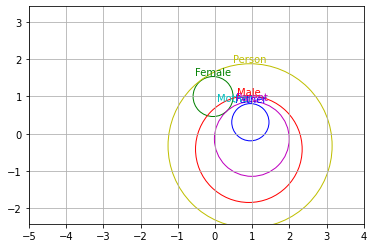

In [8]:
import matplotlib.pyplot as plt

classes = [item.split('/')[-1] for item in classes]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax =  plt.subplots()
plt.axis('equal')
ax.set_xlim(-5, 4)
ax.set_ylim(-3, 4)
for i in range(embeds.shape[0]):
    if classes[i].endswith('hing'):
        continue
    x, y = embeds[i, 0], embeds[i, 1]
    r = rs[i]
    ax.add_artist(plt.Circle(
        (x, y), r, fill=False, edgecolor=colors[i % len(colors)], label=classes[i]))
    ax.annotate(classes[i], xy=(x, y + r + 0.03), fontsize=10, ha="center", color=colors[i % len(colors)])
ax.grid(True)
plt
